<a href="https://colab.research.google.com/github/manu-eldho/artificial_intelligence/blob/main/Loan_approval_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score, roc_auc_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import files
uploaded = files.upload()

# Load CSV
df = pd.read_csv(next(iter(uploaded.keys())))
print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()


Saving loan_approval_dataset.csv to loan_approval_dataset (1).csv
Data loaded: 4269 rows, 13 columns


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [5]:
print(df.columns.tolist())

['loan_id', ' no_of_dependents', ' education', ' self_employed', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value', ' loan_status']


In [6]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

In [7]:
df['target'] = df['loan_status'].map(lambda x: 1 if str(x).strip().lower() == 'approved' else 0)

In [8]:
df[['loan_status', 'target']].head()

,loan_status,target
0,Approved,1
1,Rejected,0
2,Rejected,0
3,Rejected,0
4,Rejected,0


In [9]:
df['target'].value_counts(normalize=True) * 100

,proportion
target,
1,62.215976
0,37.784024


In [10]:
df.isnull().sum()

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

In [12]:
from sklearn.preprocessing import OneHotEncoder

# Select categorical columns (excluding target and loan_id)
categorical_cols = df.select_dtypes(include=['object']).drop(columns=['loan_status']).columns

# One-hot encode (new sklearn syntax)
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = encoder.fit_transform(df[categorical_cols])

# Create new DataFrame with encoded columns
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# Combine with numeric columns
df_final = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

df_final.head()


,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,target,education_ Not Graduate,self_employed_ Yes
0,1,2,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved,1,0.0,0.0
1,2,0,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected,0,1.0,1.0
2,3,3,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected,0,0.0,0.0
3,4,3,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected,0,0.0,0.0
4,5,5,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected,0,1.0,1.0


In [13]:
from sklearn.model_selection import train_test_split

# Features & target
X = df_final.drop(columns=['loan_status', 'target', 'loan_id'])
y = df_final['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Rejected', 'Approved'],
                yticklabels=['Rejected', 'Approved'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


In [19]:
def evaluate_model(y_true, y_pred, model_name):
    # Classification report dictionary
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    # Plot Confusion Matrix
    plot_confusion_matrix(y_true, y_pred, f"{model_name} - Confusion Matrix")

    # Plot Precision, Recall, F1 for each class
    metrics = df_report.loc[['0', '1'], ['precision', 'recall', 'f1-score']]
    metrics.plot(kind='bar', figsize=(6,4), ylim=(0,1), colormap='viridis')
    plt.title(f"{model_name} - Metrics by Class")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.show()

    return df_report

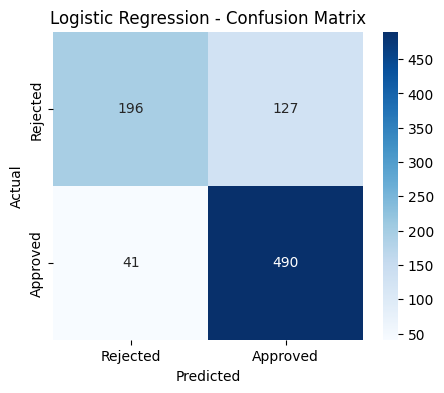

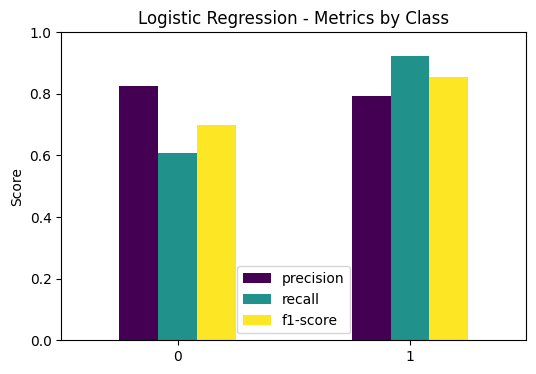

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

lr_report = evaluate_model(y_test, y_pred_lr, "Logistic Regression")

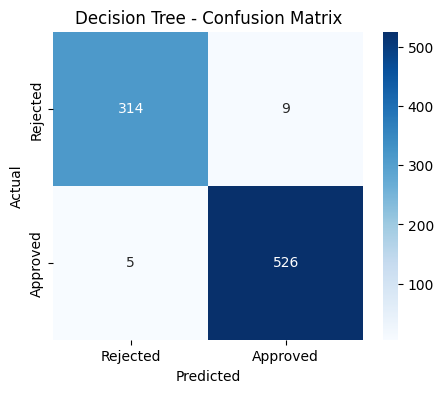

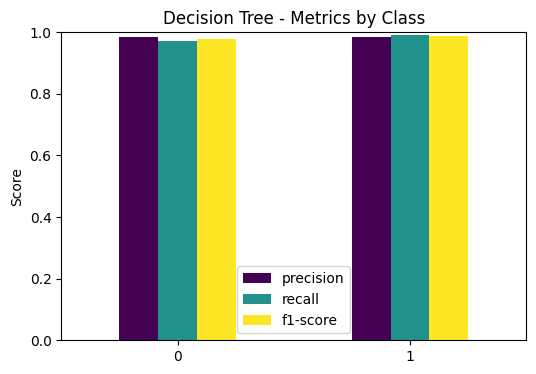

In [22]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)

dt_report = evaluate_model(y_test, y_pred_dt, "Decision Tree")


In [16]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training set only
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_sm.value_counts())


Before SMOTE: target
1    2125
0    1290
Name: count, dtype: int64
After SMOTE: target
1    2125
0    2125
Name: count, dtype: int64


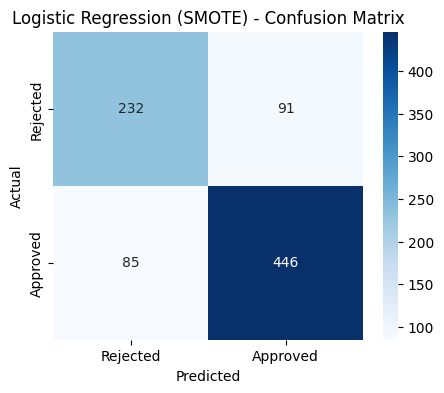

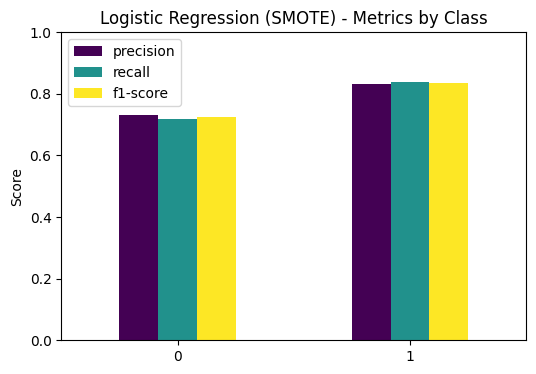

In [23]:
log_reg_sm = LogisticRegression(max_iter=1000)
log_reg_sm.fit(X_train_sm, y_train_sm)
y_pred_lr_sm = log_reg_sm.predict(X_test)

lr_sm_report = evaluate_model(y_test, y_pred_lr_sm, "Logistic Regression (SMOTE)")